## Crypto Prediction with LSTM: Litecoin (LTC)

## 30 Day Lookback

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained
- This update uses a 30 day lookback window, in order to assess whether the greater lookback time has an impact on training and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

2023-09-18 18:35:45.854351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pull LTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_LTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-18T00:00:00.0000000Z', 'time_period_end': '2023-09-19T00:00:00.0000000Z', 'time_open': '2023-09-18T00:13:16.0480000Z', 'time_close': '2023-09-18T22:22:06.8680000Z', 'price_open': 63.63, 'price_high': 67.77, 'price_low': 63.01, 'price_close': 66.35, 'volume_traded': 6865.19513386, 'trades_count': 1793}, {'time_period_start': '2023-09-17T00:00:00.0000000Z', 'time_period_end': '2023-09-18T00:00:00.0000000Z', 'time_open': '2023-09-17T00:09:58.6030000Z', 'time_close': '2023-09-17T23:55:22.9320000Z', 'price_open': 65.29, 'price_high': 65.29, 'price_low': 62.62, 'price_close': 63.58, 'volume_traded': 5013.77450216999, 'trades_count': 1291}, {'time_period_start': '2023-09-16T00:00:00.0000000Z', 'time_period_end': '2023-09-17T00:00:00.0000000Z', 'time_open': '2023-09-16T00:05:51.4950000Z', 'time_close': '2023-09-16T23:55:15.0870000Z', 'price_open': 65.79, 'price_high': 66.99, 'price_low': 64.46, 'price_close': 65.39, 'volume_traded': 3681.19385627, 'trades_count'

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-18T00:00:00.0000000Z,2023-09-19T00:00:00.0000000Z,2023-09-18T00:13:16.0480000Z,2023-09-18T22:22:06.8680000Z,63.63,67.77,63.01,66.35,6865.195134,1793
1,2023-09-17T00:00:00.0000000Z,2023-09-18T00:00:00.0000000Z,2023-09-17T00:09:58.6030000Z,2023-09-17T23:55:22.9320000Z,65.29,65.29,62.62,63.58,5013.774502,1291
2,2023-09-16T00:00:00.0000000Z,2023-09-17T00:00:00.0000000Z,2023-09-16T00:05:51.4950000Z,2023-09-16T23:55:15.0870000Z,65.79,66.99,64.46,65.39,3681.193856,978
3,2023-09-15T00:00:00.0000000Z,2023-09-16T00:00:00.0000000Z,2023-09-15T00:01:26.9470000Z,2023-09-15T23:49:47.7880000Z,62.86,66.22,62.63,65.99,3986.624710,1222
4,2023-09-14T00:00:00.0000000Z,2023-09-15T00:00:00.0000000Z,2023-09-14T00:02:53.7140000Z,2023-09-14T23:58:41.9780000Z,62.20,63.34,62.00,62.86,4454.170503,1208


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-06-28,42.04
2017-06-29,40.50
2017-06-30,39.88
2017-07-01,38.10
2017-07-02,41.42


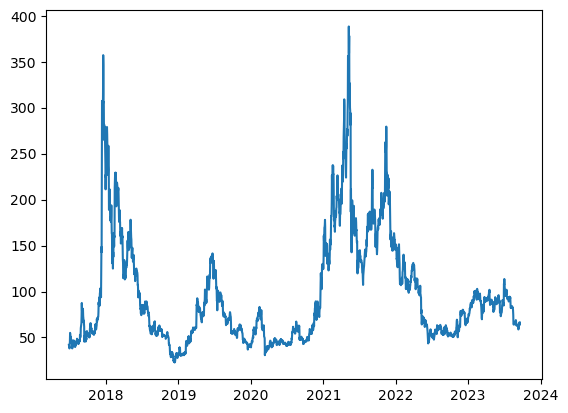

In [5]:
#plot historical ltc price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 30 

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#scale data
log_transformed_data = np.log(shifted_df_as_np)



# split y from features
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape

((2231, 30), (2231,), (2231,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1784, 30), (1784,), (223, 30), (223,), (224, 30), (224,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-18 18:36:06.025701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
56/56 [==============================] - 6s 55ms/step - loss: 8.2754 - mean_absolute_error: 2.3948 - val_loss: 0.3072 - val_mean_absolute_error: 0.5258
Epoch 2/100
56/56 [==============================] - 1s 25ms/step - loss: 0.3747 - mean_absolute_error: 0.5215 - val_loss: 0.1468 - val_mean_absolute_error: 0.3473
Epoch 3/100
56/56 [==============================] - 1s 24ms/step - loss: 0.2958 - mean_absolute_error: 0.4699 - val_loss: 0.0938 - val_mean_absolute_error: 0.2738
Epoch 4/100
56/56 [==============================] - 1s 27ms/step - loss: 0.1087 - mean_absolute_error: 0.2537 - val_loss: 0.0423 - val_mean_absolute_error: 0.1829
Epoch 5/100
56/56 [==============================] - 2s 28ms/step - loss: 0.0398 - mean_absolute_error: 0.1494 - val_loss: 0.0095 - val_mean_absolute_error: 0.0755
Epoch 6/100
56/56 [==============================] - 2s 28ms/step - loss: 0.0277 - mean_absolute_error: 0.1256 - val_loss: 0.0108 - val_mean_absolute_error: 0.0876
Epoch 7/100
56/5

Epoch 51/100
56/56 [==============================] - 3s 51ms/step - loss: 0.0047 - mean_absolute_error: 0.0493 - val_loss: 0.0054 - val_mean_absolute_error: 0.0630
Epoch 52/100
56/56 [==============================] - 3s 53ms/step - loss: 0.0050 - mean_absolute_error: 0.0518 - val_loss: 0.0020 - val_mean_absolute_error: 0.0317
Epoch 53/100
56/56 [==============================] - 2s 36ms/step - loss: 0.0043 - mean_absolute_error: 0.0476 - val_loss: 0.0047 - val_mean_absolute_error: 0.0578
Epoch 54/100
56/56 [==============================] - 2s 27ms/step - loss: 0.0047 - mean_absolute_error: 0.0501 - val_loss: 0.0025 - val_mean_absolute_error: 0.0392
Epoch 55/100
56/56 [==============================] - 1s 27ms/step - loss: 0.0044 - mean_absolute_error: 0.0477 - val_loss: 0.0036 - val_mean_absolute_error: 0.0495
Epoch 56/100
56/56 [==============================] - 1s 23ms/step - loss: 0.0046 - mean_absolute_error: 0.0489 - val_loss: 0.0028 - val_mean_absolute_error: 0.0396
Epoch 57/1

56/56 [==============================] - 1s 7ms/step


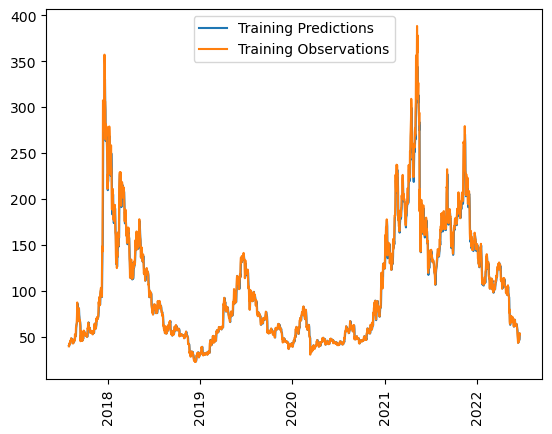

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0017226339550688863
Val MAE: 0.029764389619231224


7/7 [==============================] - 0s 9ms/step


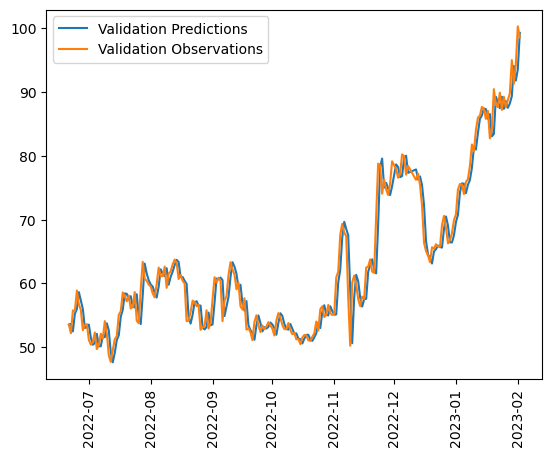

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0015110298991203308
Test MAE: 0.026617811992764473


7/7 [==============================] - 0s 7ms/step


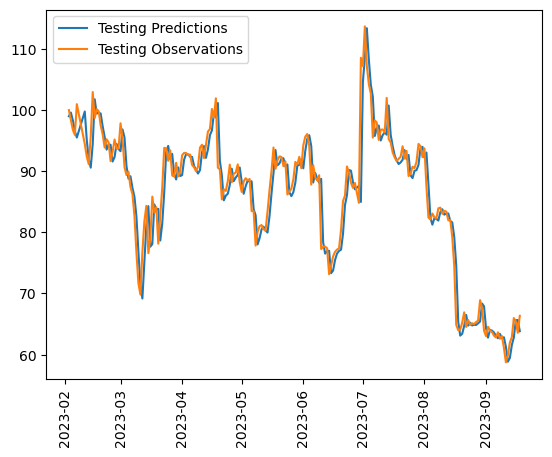

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9230512048436925


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((870,),
 (870, 30),
 (870,),
 (134,),
 (134, 30),
 (134,),
 (112,),
 (112, 30),
 (112,))

In [42]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
56/56 [==============================] - 6s 42ms/step - loss: 4.3796 - mean_absolute_error: 1.5495 - val_loss: 0.0477 - val_mean_absolute_error: 0.1967
Epoch 2/300
56/56 [==============================] - 2s 32ms/step - loss: 0.1970 - mean_absolute_error: 0.3647 - val_loss: 0.0353 - val_mean_absolute_error: 0.1633
Epoch 3/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0348 - mean_absolute_error: 0.1406 - val_loss: 0.0197 - val_mean_absolute_error: 0.1206
Epoch 4/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0231 - mean_absolute_error: 0.1124 - val_loss: 0.0046 - val_mean_absolute_error: 0.0538
Epoch 5/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0188 - mean_absolute_error: 0.1011 - val_loss: 0.0055 - val_mean_absolute_error: 0.0589
Epoch 6/300
56/56 [==============================] - 2s 39ms/step - loss: 0.0166 - mean_absolute_error: 0.0953 - val_loss: 0.0039 - val_mean_absolute_error: 0.0484
Epoch 7/300
56/5

Epoch 51/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0046 - mean_absolute_error: 0.0493 - val_loss: 0.0021 - val_mean_absolute_error: 0.0328
Epoch 52/300
56/56 [==============================] - 1s 22ms/step - loss: 0.0048 - mean_absolute_error: 0.0510 - val_loss: 0.0033 - val_mean_absolute_error: 0.0468
Epoch 53/300
56/56 [==============================] - 1s 22ms/step - loss: 0.0043 - mean_absolute_error: 0.0459 - val_loss: 0.0021 - val_mean_absolute_error: 0.0343
Epoch 54/300
56/56 [==============================] - 1s 27ms/step - loss: 0.0050 - mean_absolute_error: 0.0523 - val_loss: 0.0019 - val_mean_absolute_error: 0.0317
Epoch 55/300
56/56 [==============================] - 2s 31ms/step - loss: 0.0052 - mean_absolute_error: 0.0538 - val_loss: 0.0059 - val_mean_absolute_error: 0.0673
Epoch 56/300
56/56 [==============================] - 2s 27ms/step - loss: 0.0047 - mean_absolute_error: 0.0499 - val_loss: 0.0020 - val_mean_absolute_error: 0.0325
Epoch 57/3

Epoch 101/300
56/56 [==============================] - 3s 55ms/step - loss: 0.0040 - mean_absolute_error: 0.0458 - val_loss: 0.0017 - val_mean_absolute_error: 0.0303
Epoch 102/300
56/56 [==============================] - 2s 33ms/step - loss: 0.0038 - mean_absolute_error: 0.0442 - val_loss: 0.0021 - val_mean_absolute_error: 0.0338
Epoch 103/300
56/56 [==============================] - 2s 41ms/step - loss: 0.0043 - mean_absolute_error: 0.0479 - val_loss: 0.0017 - val_mean_absolute_error: 0.0301
Epoch 104/300
56/56 [==============================] - 2s 30ms/step - loss: 0.0042 - mean_absolute_error: 0.0469 - val_loss: 0.0033 - val_mean_absolute_error: 0.0463
Epoch 105/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0041 - mean_absolute_error: 0.0463 - val_loss: 0.0027 - val_mean_absolute_error: 0.0411
Epoch 106/300
56/56 [==============================] - 1s 23ms/step - loss: 0.0039 - mean_absolute_error: 0.0442 - val_loss: 0.0017 - val_mean_absolute_error: 0.0302
Epoc

56/56 [==============================] - 1s 23ms/step - loss: 0.0049 - mean_absolute_error: 0.0528 - val_loss: 0.0017 - val_mean_absolute_error: 0.0299
Epoch 151/300
56/56 [==============================] - 1s 21ms/step - loss: 0.0044 - mean_absolute_error: 0.0484 - val_loss: 0.0022 - val_mean_absolute_error: 0.0345
Epoch 152/300
56/56 [==============================] - 1s 22ms/step - loss: 0.0042 - mean_absolute_error: 0.0473 - val_loss: 0.0026 - val_mean_absolute_error: 0.0402
Epoch 153/300
56/56 [==============================] - 1s 21ms/step - loss: 0.0038 - mean_absolute_error: 0.0441 - val_loss: 0.0039 - val_mean_absolute_error: 0.0522
Epoch 154/300
56/56 [==============================] - 1s 24ms/step - loss: 0.0043 - mean_absolute_error: 0.0481 - val_loss: 0.0019 - val_mean_absolute_error: 0.0329
Epoch 155/300
56/56 [==============================] - 2s 41ms/step - loss: 0.0039 - mean_absolute_error: 0.0442 - val_loss: 0.0017 - val_mean_absolute_error: 0.0294
Epoch 156/300
56/5

56/56 [==============================] - 1s 24ms/step - loss: 0.0040 - mean_absolute_error: 0.0457 - val_loss: 0.0017 - val_mean_absolute_error: 0.0299
Epoch 200/300
56/56 [==============================] - 1s 25ms/step - loss: 0.0038 - mean_absolute_error: 0.0434 - val_loss: 0.0037 - val_mean_absolute_error: 0.0512
Epoch 201/300
56/56 [==============================] - 1s 22ms/step - loss: 0.0041 - mean_absolute_error: 0.0450 - val_loss: 0.0017 - val_mean_absolute_error: 0.0302
Epoch 202/300
56/56 [==============================] - 1s 22ms/step - loss: 0.0041 - mean_absolute_error: 0.0460 - val_loss: 0.0017 - val_mean_absolute_error: 0.0296
Epoch 203/300
56/56 [==============================] - 1s 22ms/step - loss: 0.0043 - mean_absolute_error: 0.0484 - val_loss: 0.0017 - val_mean_absolute_error: 0.0295
Epoch 204/300
56/56 [==============================] - 1s 21ms/step - loss: 0.0035 - mean_absolute_error: 0.0413 - val_loss: 0.0022 - val_mean_absolute_error: 0.0357
Epoch 205/300
56/5

56/56 [==============================] - 1s 22ms/step - loss: 0.0046 - mean_absolute_error: 0.0499 - val_loss: 0.0050 - val_mean_absolute_error: 0.0620
Epoch 249/300
56/56 [==============================] - 1s 22ms/step - loss: 0.0046 - mean_absolute_error: 0.0493 - val_loss: 0.0037 - val_mean_absolute_error: 0.0510
Epoch 250/300
56/56 [==============================] - 1s 23ms/step - loss: 0.0036 - mean_absolute_error: 0.0419 - val_loss: 0.0017 - val_mean_absolute_error: 0.0298
Epoch 251/300
56/56 [==============================] - 2s 27ms/step - loss: 0.0048 - mean_absolute_error: 0.0518 - val_loss: 0.0018 - val_mean_absolute_error: 0.0301
Epoch 252/300
56/56 [==============================] - 2s 30ms/step - loss: 0.0037 - mean_absolute_error: 0.0425 - val_loss: 0.0022 - val_mean_absolute_error: 0.0367
Epoch 253/300
56/56 [==============================] - 1s 26ms/step - loss: 0.0036 - mean_absolute_error: 0.0418 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313
Epoch 254/300
56/5

56/56 [==============================] - 2s 27ms/step - loss: 0.0039 - mean_absolute_error: 0.0439 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311
Epoch 298/300
56/56 [==============================] - 2s 38ms/step - loss: 0.0038 - mean_absolute_error: 0.0443 - val_loss: 0.0031 - val_mean_absolute_error: 0.0444
Epoch 299/300
56/56 [==============================] - 2s 27ms/step - loss: 0.0039 - mean_absolute_error: 0.0449 - val_loss: 0.0017 - val_mean_absolute_error: 0.0297
Epoch 300/300
56/56 [==============================] - 2s 28ms/step - loss: 0.0042 - mean_absolute_error: 0.0465 - val_loss: 0.0028 - val_mean_absolute_error: 0.0412


56/56 [==============================] - 1s 9ms/step


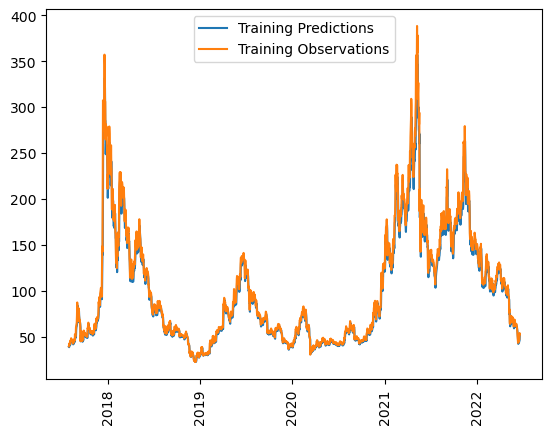

In [43]:
#Second model observations
train_predictions2 = model2.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions2))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [44]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0023433403111994267
Val MAE: 0.040084194391965866


5/5 [==============================] - 0s 10ms/step


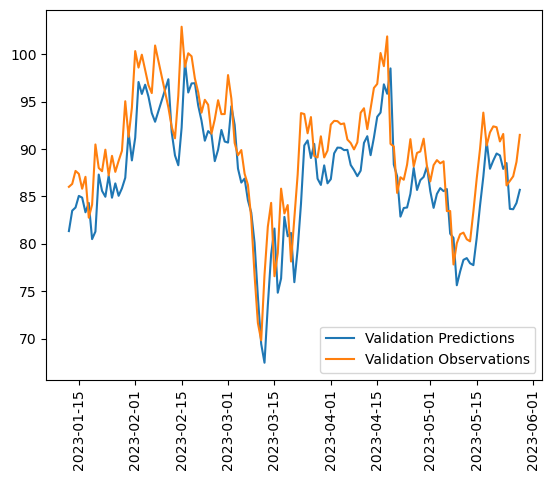

In [45]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [46]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0025268173776566982
Test MAE: 0.03902151808142662


In [47]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 11ms/step
R2 Score:  0.9118328690256425


4/4 [==============================] - 0s 7ms/step


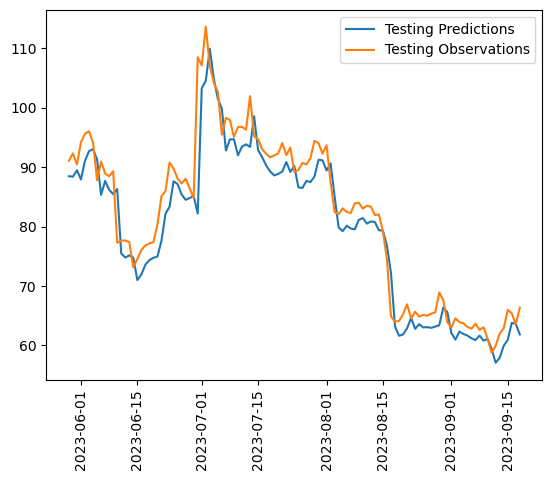

In [48]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
28/28 [==============================] - 6s 76ms/step - loss: 21.2129 - mean_absolute_error: 4.5703 - val_loss: 17.4358 - val_mean_absolute_error: 4.1750
Epoch 2/300
28/28 [==============================] - 1s 35ms/step - loss: 17.7803 - mean_absolute_error: 4.1796 - val_loss: 14.6342 - val_mean_absolute_error: 3.8249
Epoch 3/300
28/28 [==============================] - 1s 26ms/step - loss: 14.8988 - mean_absolute_error: 3.8232 - val_loss: 11.9504 - val_mean_absolute_error: 3.4563
Epoch 4/300
28/28 [==============================] - 1s 31ms/step - loss: 11.8631 - mean_absolute_error: 3.4020 - val_loss: 8.7431 - val_mean_absolute_error: 2.9561
Epoch 5/300
28/28 [==============================] - 1s 30ms/step - loss: 8.2376 - mean_absolute_error: 2.8156 - val_loss: 5.1138 - val_mean_absolute_error: 2.2603
Epoch 6/300
28/28 [==============================] - 1s 30ms/step - loss: 4.4803 - mean_absolute_error: 2.0331 - val_loss: 1.9448 - val_mean_absolute_error: 1.3928
Epoch 7/3

Epoch 51/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0151 - mean_absolute_error: 0.0929 - val_loss: 0.0050 - val_mean_absolute_error: 0.0545
Epoch 52/300
28/28 [==============================] - 1s 29ms/step - loss: 0.0149 - mean_absolute_error: 0.0914 - val_loss: 0.0048 - val_mean_absolute_error: 0.0548
Epoch 53/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0146 - mean_absolute_error: 0.0916 - val_loss: 0.0051 - val_mean_absolute_error: 0.0574
Epoch 54/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0147 - mean_absolute_error: 0.0911 - val_loss: 0.0046 - val_mean_absolute_error: 0.0531
Epoch 55/300
28/28 [==============================] - 1s 25ms/step - loss: 0.0148 - mean_absolute_error: 0.0912 - val_loss: 0.0046 - val_mean_absolute_error: 0.0538
Epoch 56/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0140 - mean_absolute_error: 0.0886 - val_loss: 0.0045 - val_mean_absolute_error: 0.0523
Epoch 57/3

Epoch 101/300
28/28 [==============================] - 1s 33ms/step - loss: 0.0095 - mean_absolute_error: 0.0711 - val_loss: 0.0038 - val_mean_absolute_error: 0.0465
Epoch 102/300
28/28 [==============================] - 1s 30ms/step - loss: 0.0098 - mean_absolute_error: 0.0723 - val_loss: 0.0047 - val_mean_absolute_error: 0.0537
Epoch 103/300
28/28 [==============================] - 1s 33ms/step - loss: 0.0096 - mean_absolute_error: 0.0714 - val_loss: 0.0030 - val_mean_absolute_error: 0.0416
Epoch 104/300
28/28 [==============================] - 1s 30ms/step - loss: 0.0093 - mean_absolute_error: 0.0705 - val_loss: 0.0038 - val_mean_absolute_error: 0.0485
Epoch 105/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0092 - mean_absolute_error: 0.0694 - val_loss: 0.0031 - val_mean_absolute_error: 0.0421
Epoch 106/300
28/28 [==============================] - 1s 24ms/step - loss: 0.0094 - mean_absolute_error: 0.0717 - val_loss: 0.0030 - val_mean_absolute_error: 0.0413
Epoc

28/28 [==============================] - 1s 24ms/step - loss: 0.0070 - mean_absolute_error: 0.0612 - val_loss: 0.0028 - val_mean_absolute_error: 0.0403
Epoch 151/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0070 - mean_absolute_error: 0.0612 - val_loss: 0.0028 - val_mean_absolute_error: 0.0403
Epoch 152/300
28/28 [==============================] - 1s 34ms/step - loss: 0.0073 - mean_absolute_error: 0.0629 - val_loss: 0.0033 - val_mean_absolute_error: 0.0448
Epoch 153/300
28/28 [==============================] - 1s 30ms/step - loss: 0.0076 - mean_absolute_error: 0.0649 - val_loss: 0.0039 - val_mean_absolute_error: 0.0494
Epoch 154/300
28/28 [==============================] - 1s 32ms/step - loss: 0.0073 - mean_absolute_error: 0.0624 - val_loss: 0.0027 - val_mean_absolute_error: 0.0397
Epoch 155/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0069 - mean_absolute_error: 0.0606 - val_loss: 0.0032 - val_mean_absolute_error: 0.0435
Epoch 156/300
28/2

28/28 [==============================] - 1s 29ms/step - loss: 0.0059 - mean_absolute_error: 0.0557 - val_loss: 0.0023 - val_mean_absolute_error: 0.0354
Epoch 200/300
28/28 [==============================] - 1s 54ms/step - loss: 0.0057 - mean_absolute_error: 0.0559 - val_loss: 0.0023 - val_mean_absolute_error: 0.0362
Epoch 201/300
28/28 [==============================] - 1s 29ms/step - loss: 0.0058 - mean_absolute_error: 0.0557 - val_loss: 0.0023 - val_mean_absolute_error: 0.0373
Epoch 202/300
28/28 [==============================] - 1s 39ms/step - loss: 0.0056 - mean_absolute_error: 0.0543 - val_loss: 0.0022 - val_mean_absolute_error: 0.0359
Epoch 203/300
28/28 [==============================] - 1s 37ms/step - loss: 0.0056 - mean_absolute_error: 0.0548 - val_loss: 0.0030 - val_mean_absolute_error: 0.0419
Epoch 204/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0057 - mean_absolute_error: 0.0553 - val_loss: 0.0028 - val_mean_absolute_error: 0.0422
Epoch 205/300
28/2

28/28 [==============================] - 1s 32ms/step - loss: 0.0048 - mean_absolute_error: 0.0505 - val_loss: 0.0030 - val_mean_absolute_error: 0.0444
Epoch 249/300
28/28 [==============================] - 1s 32ms/step - loss: 0.0048 - mean_absolute_error: 0.0504 - val_loss: 0.0020 - val_mean_absolute_error: 0.0334
Epoch 250/300
28/28 [==============================] - 1s 31ms/step - loss: 0.0049 - mean_absolute_error: 0.0507 - val_loss: 0.0019 - val_mean_absolute_error: 0.0325
Epoch 251/300
28/28 [==============================] - 1s 33ms/step - loss: 0.0048 - mean_absolute_error: 0.0501 - val_loss: 0.0019 - val_mean_absolute_error: 0.0331
Epoch 252/300
28/28 [==============================] - 1s 30ms/step - loss: 0.0049 - mean_absolute_error: 0.0512 - val_loss: 0.0020 - val_mean_absolute_error: 0.0339
Epoch 253/300
28/28 [==============================] - 1s 24ms/step - loss: 0.0051 - mean_absolute_error: 0.0527 - val_loss: 0.0021 - val_mean_absolute_error: 0.0346
Epoch 254/300
28/2

28/28 [==============================] - 1s 29ms/step - loss: 0.0042 - mean_absolute_error: 0.0466 - val_loss: 0.0024 - val_mean_absolute_error: 0.0383
Epoch 298/300
28/28 [==============================] - 1s 31ms/step - loss: 0.0045 - mean_absolute_error: 0.0488 - val_loss: 0.0017 - val_mean_absolute_error: 0.0304
Epoch 299/300
28/28 [==============================] - 1s 36ms/step - loss: 0.0042 - mean_absolute_error: 0.0463 - val_loss: 0.0019 - val_mean_absolute_error: 0.0336
Epoch 300/300
28/28 [==============================] - 1s 30ms/step - loss: 0.0043 - mean_absolute_error: 0.0468 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311


28/28 [==============================] - 1s 9ms/step


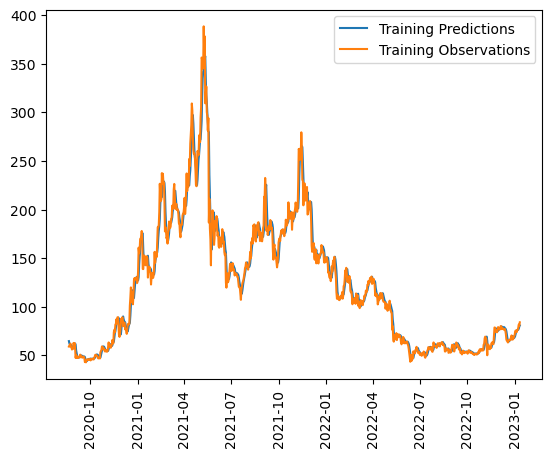

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0017812915612012148
Val MAE: 0.031115390360355377


5/5 [==============================] - 0s 9ms/step


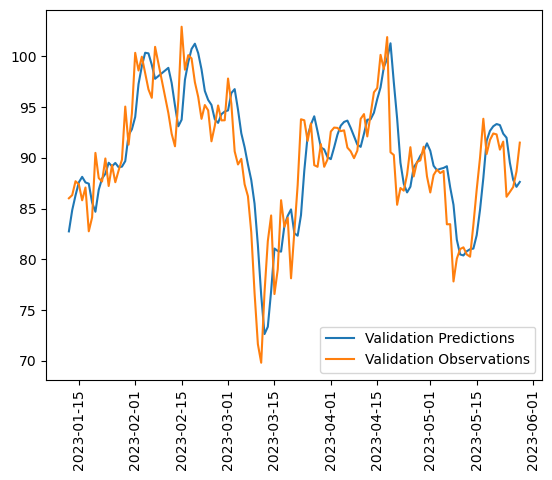

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0025730805937200785
Test MAE: 0.034148067235946655


4/4 [==============================] - 0s 8ms/step


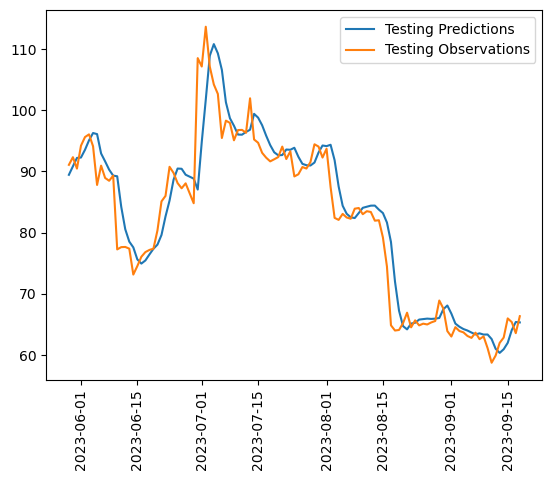

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9102183888312457


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the highest scoring model for future predictions

In [68]:
# Use the first model to predict future values since it has the highest r2 score

# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test1[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test1[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

# add future dates for predictions
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 32ms/step
[4.1563425, 4.150404, 4.1497426, 4.150387, 4.1508236, 4.1509433, 4.150932]
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24
2023-09-25


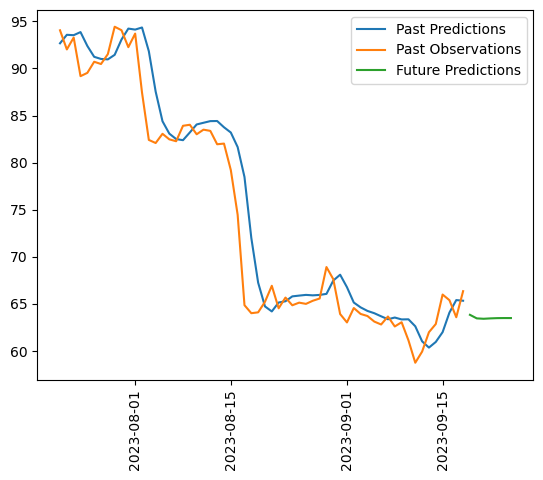

In [69]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [58]:
# Export model to HDF5 file
model.save("H5_Files/ltc_30_day_1.h5")

In [59]:
# Export model to HDF5 file
model2.save("H5_Files/ltc_30_day_2.h5")

In [60]:
# Export model to HDF5 file
model3.save("H5_Files/ltc_30_day_3.h5")

In [61]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-06-20,80.37,77.146187,74.954849,78.042274
2023-06-21,85.10,79.751328,77.643028,79.612915
2023-06-22,86.00,84.440498,82.169830,82.645966
2023-06-23,90.75,86.086105,83.323799,85.229919
2023-06-24,89.75,90.167877,87.625336,88.645683
...,...,...,...,...
2023-09-14,62.86,61.597637,59.933804,60.956375
2023-09-15,65.99,62.816738,60.917347,61.996506
2023-09-16,65.39,65.635262,63.791573,64.074417


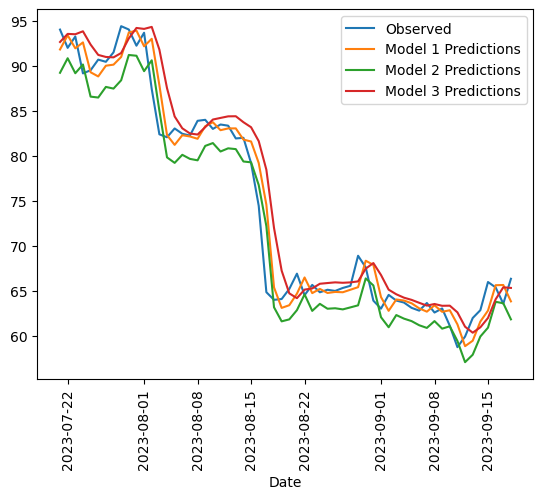

In [62]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [63]:
#output prediction data to csv
df.to_csv('output/ltc_predict_30.csv') 

In [64]:
#output original historical data to csv
data.to_csv('output/ltc_lifetime_30.csv')

In [65]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.9230512048436925
Model 2 R2 Score:  0.9118328690256425
Model 3 R2 Score:  0.9102183888312457
